#IMPORTS

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

In [4]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path

In [5]:
import pandas as pd
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

In [7]:
import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import max_norm
from keras import backend as K


In [8]:
import cv2

In [9]:
from skimage.io import imread
from skimage.transform import resize

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [11]:
from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px

#Data Fetching

In [12]:
#Kaggle Username : prajwalbhandarkar
#Kaggle Key : 74164b06d3aa9376f3fec17a832d135b

In [13]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalbhandarkar
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:28<00:00, 85.8MB/s]


In [14]:
base_dir = Path("chest-xray-pneumonia/chest_xray/chest_xray/")

In [15]:
train_dir = base_dir /"train/"
val_dir = base_dir /"val/"
test_dir = base_dir /"test/"

#Changing the environment CPU to GPU (Check the GPU Environment)
##Not done yet

In [16]:
tf.__version__

'2.15.0'

In [17]:
import tensorflow as tf

# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available.")
else:
    print("GPU is not found.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is not found.


In [18]:
import tensorflow as tf

# Check if GPU is available using tf.config.list_physical_devices
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available.")
else:
    print("GPU is not found.")


GPU is not found.


In [19]:
!pip install numpy
!pip install h5py
!pip install keras_applications
!pip install keras_preprocessing





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [20]:
!pip install tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


#Loading Data

In [21]:
os.listdir(train_dir)

['NORMAL', 'PNEUMONIA', '.DS_Store']

In [22]:
train_normal_dir = train_dir /"NORMAL" #to set the path to the normals in train set
train_pneumonia_dir = train_dir /"PNEUMONIA" #to set the path to the pneumonias in train set

In [23]:
os.listdir(val_dir)

['NORMAL', 'PNEUMONIA', '.DS_Store']

In [24]:
valid_normal_dir = val_dir /"NORMAL" #to set the path to the normals in validation set
valid_pneumonia_dir = val_dir /"PNEUMONIA" #to set the path to the pneumonias in validation set

In [25]:
os.listdir(test_dir)

['NORMAL', 'PNEUMONIA', '.DS_Store']

In [26]:
test_normal_dir = test_dir /"NORMAL" #to set the path to the normals in test set
test_pneumonia_dir = test_dir /"PNEUMONIA" #to set the path to the pneumonias in test set

#Labeling

In [27]:
train_normal= train_normal_dir.glob("*.jpeg") #to take the normal images from train set
train_pneumonia=train_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the train set
train_set=[]#to add all the train data into one list, we created a blank list

In [28]:
for img in train_normal: #to add every image of normals in trainset to the list
  train_set.append((img, 0)) #we add 0 with normal images as label
for img in train_pneumonia:#to add every image of pneumonias in trainset to the list
  train_set.append((img, 1)) #we add 1 with pneumonia images as label

In [29]:
print(train_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0475-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1376-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0732-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0559-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0804-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0537-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0684-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0635-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0460-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0465-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/ches

In [30]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features

In [31]:
train_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0


In [32]:
train_set=train_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
train_set=train_set.reset_index(drop=True) #to set the indexes as if first time
train_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1


#Setting Data set for validation

In [33]:
valid_normal= valid_normal_dir.glob("*.jpeg") #to take the normal images from validation set
valid_pneumonia=valid_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the validation set
valid_set=[] #to add all the validation data into one list, we created a blank list

In [34]:
for img in valid_normal: #to add every image of normals in validationset to the list
  valid_set.append((img, 0)) #we add 0 with normal images as label
for img in valid_pneumonia:#to add every image of pneumonias in validationset to the list
  valid_set.append((img, 1)) #we add 1 with pneumonia images as label

In [35]:
print(valid_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'), 1), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'),

In [36]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
valid_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [37]:
valid_set=valid_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
valid_set=valid_set.reset_index(drop=True) #to set the indexes as if first time
valid_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,1


In [38]:
test_normal= test_normal_dir.glob("*.jpeg") #to take the normal images from test set
test_pneumonia=test_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the test set
test_set=[]#to add all the test data into one list, we created a blank list


In [39]:
for img in test_normal: #to add every image of normals in test set to the list
  test_set.append((img, 0)) #we add 0 with normal images as label
for img in test_pneumonia:#to add every image of pneumonias in test set to the list
  test_set.append((img, 1)) #we add 1 with pneumonia images as label

In [40]:
print(test_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0123-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0273-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0339-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0275-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0051-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0376-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0378-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0093-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0067-0001.jpeg'), 0), (PosixPath

In [41]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
test_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0


In [42]:
test_set=test_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
test_set=test_set.reset_index(drop=True) #to set the indexes as if first time
test_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1


#Visualization

In [43]:
# Normal Image
train_normal_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [44]:
train_pneumonia_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


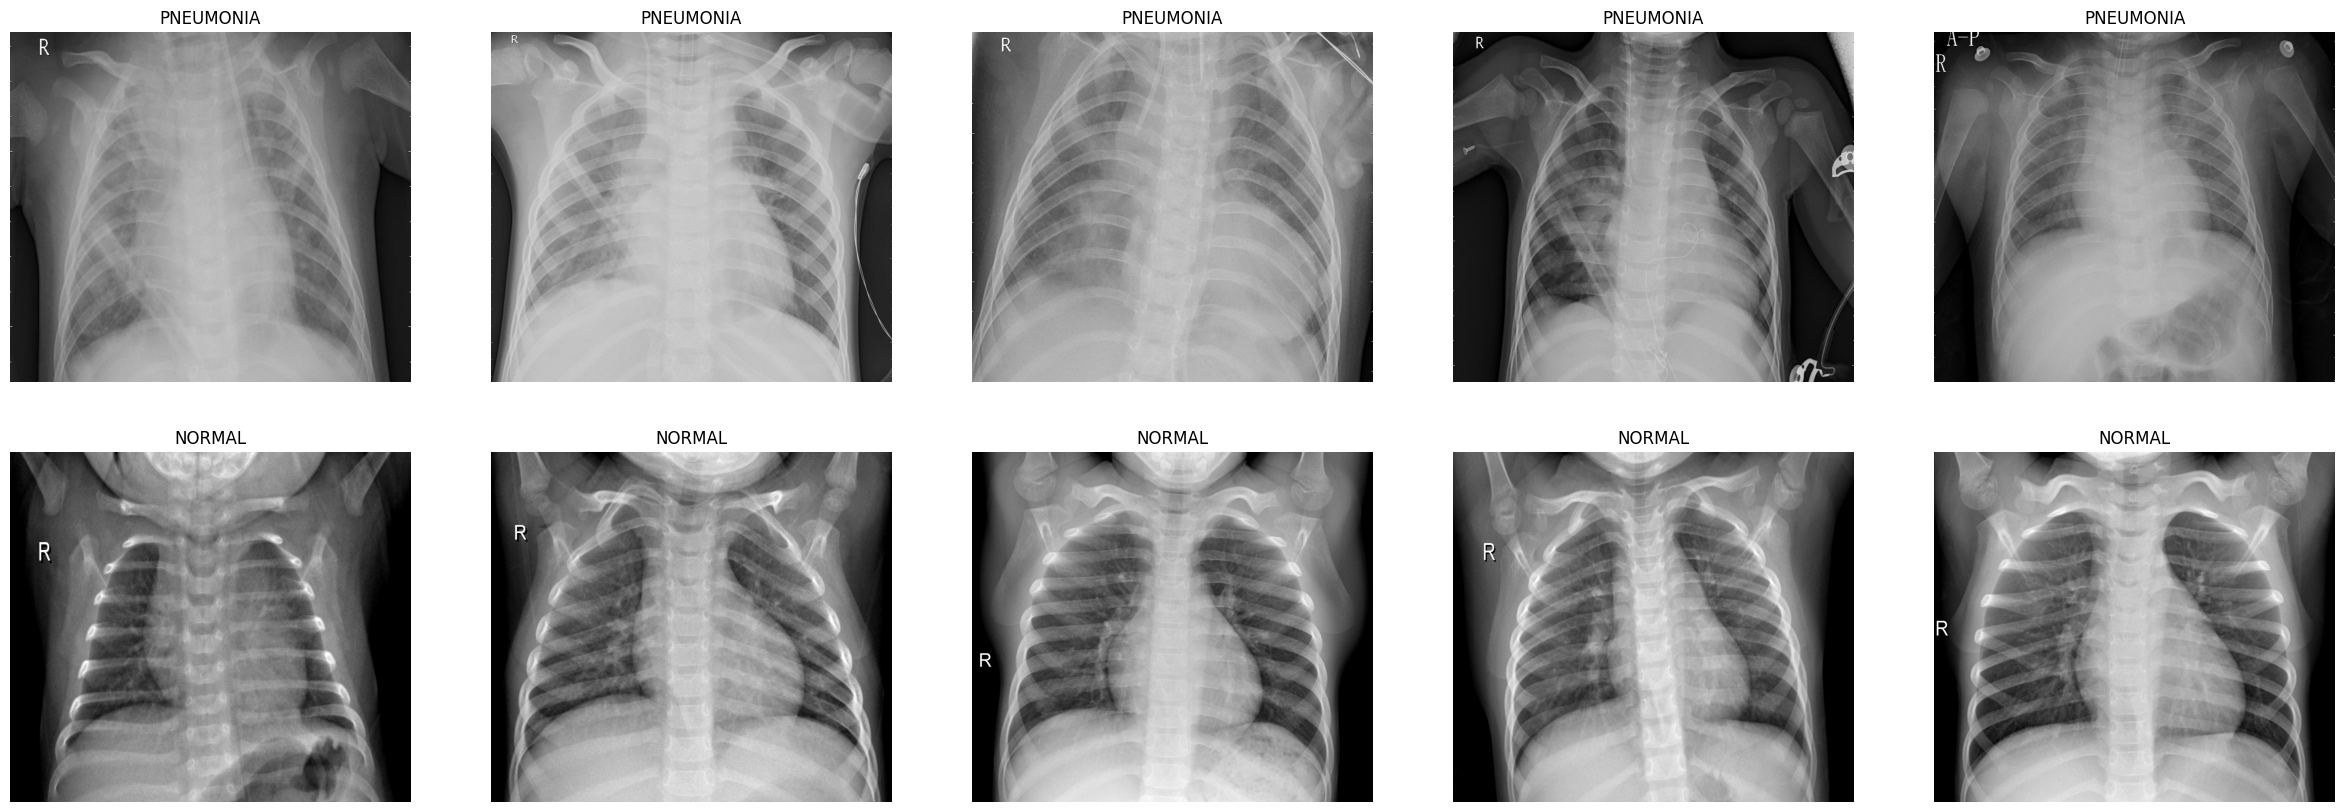

In [45]:
# Get few samples for both the classes
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()

# Concate the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

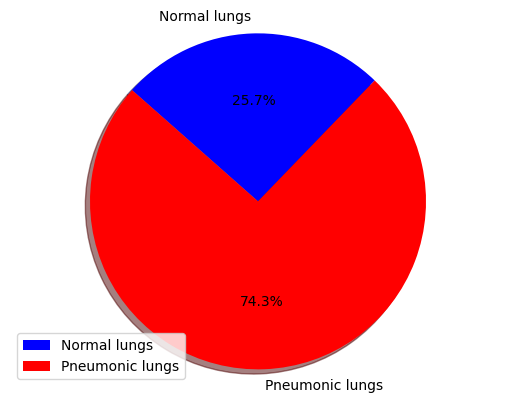

In [46]:
fig1,ax1= plt.subplots()
sizes=[train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Normal lungs","Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b","r"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

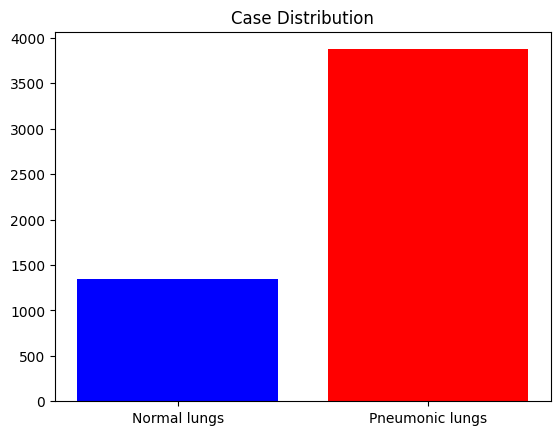

In [47]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "red"])
plt.title("Case Distribution")

#Data Preparation
##Data Distribution

In [48]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [49]:
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [50]:
# initialize multiple lists
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

#Data Normalization

In [51]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [52]:
#Reshaping Data
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#DATA AUGMENTATION

In [53]:
# normalize and augment images
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images

image_generator.fit(X_train)

#Data Modelling

In [54]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [55]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [56]:
history = model.fit(image_generator.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=image_generator.flow(X_val, y_val), callbacks=[learning_rate_reduction])


Epoch 1/15
183/183 [==============================] - 558s 3s/step - loss: 0.5193 - accuracy: 0.8407 - val_loss: 8.0357 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 2/15
183/183 [==============================] - 517s 3s/step - loss: 0.2769 - accuracy: 0.8943 - val_loss: 23.9505 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 3/15
183/183 [==============================] - 513s 3s/step - loss: 0.2588 - accuracy: 0.9062 - val_loss: 4.7210 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 4/15
183/183 [==============================] - 540s 3s/step - loss: 0.2315 - accuracy: 0.9187 - val_loss: 0.1784 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 5/15
183/183 [==============================] - 512s 3s/step - loss: 0.1987 - accuracy: 0.9296 - val_loss: 2.4363 - val_accuracy: 0.3526 - lr: 0.0010
Epoch 6/15
183/183 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9284
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
183/183 [==============================] - 537s

In [57]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

183/183 [==============================] - 104s 558ms/step - loss: 0.5542 - accuracy: 0.8099
Loss of the model is -  0.5542347431182861
183/183 [==============================] - 100s 542ms/step - loss: 0.5542 - accuracy: 0.8099
Accuracy of the model is -  80.99385499954224 %


#Evaluation

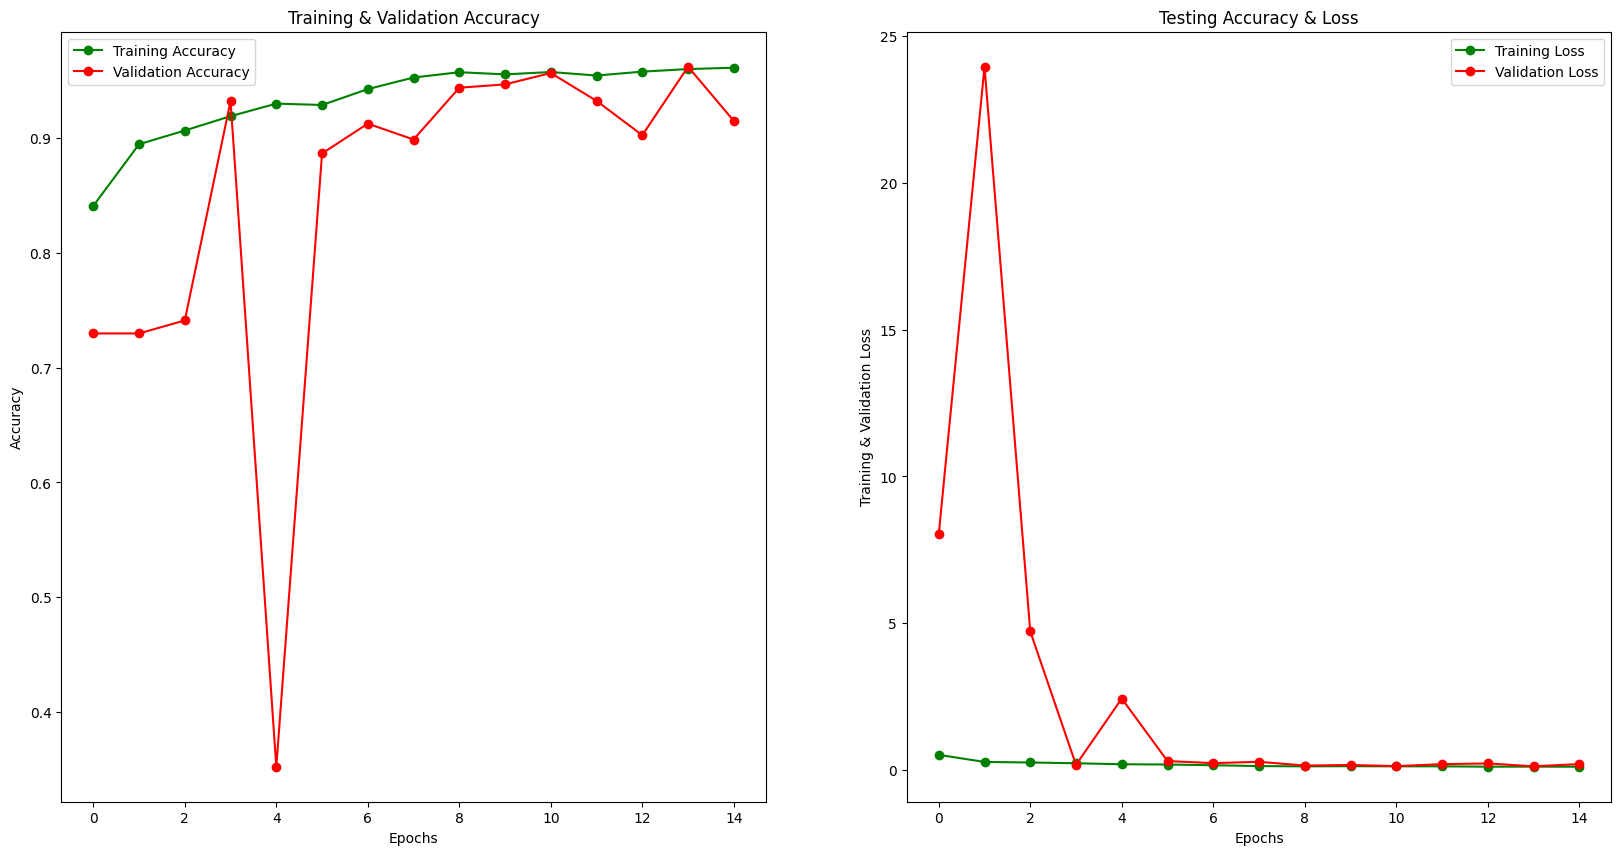

In [58]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [59]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

183/183 [==============================] - 136s 741ms/step


array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1], dtype=int32)

In [60]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.74      0.85      4273
   Normal (Class 1)       0.59      0.99      0.74      1583

           accuracy                           0.81      5856
          macro avg       0.79      0.87      0.79      5856
       weighted avg       0.89      0.81      0.82      5856



In [61]:
cm = confusion_matrix(y_test, predictions)
cm

array([[3171, 1102],
       [  11, 1572]])

In [62]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

<Axes: >

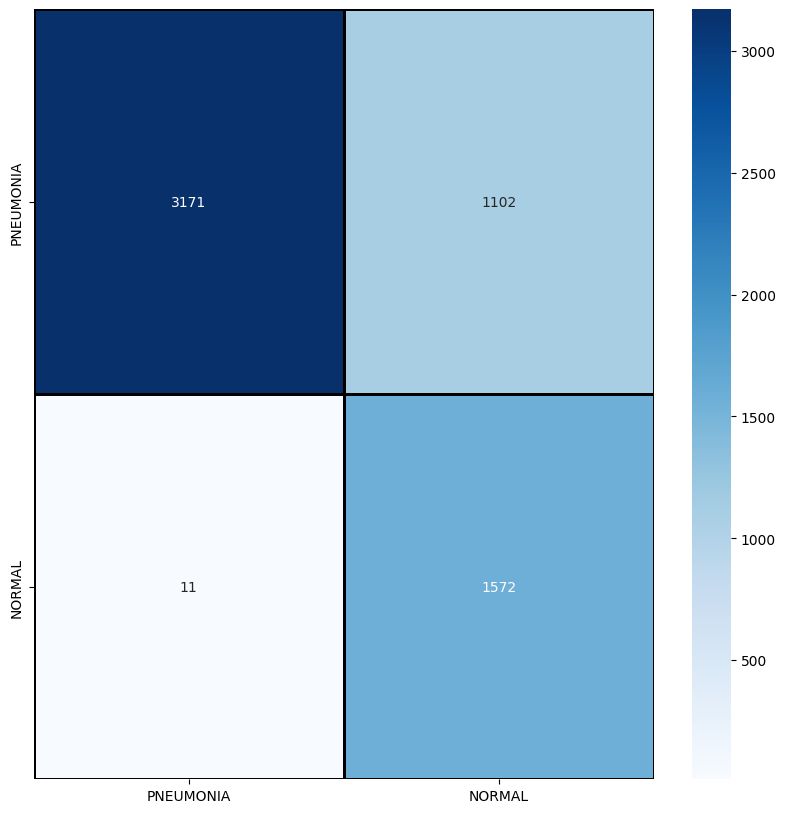

In [63]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [64]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

#Proof

<ipython-input-65-194eb1c1c186>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


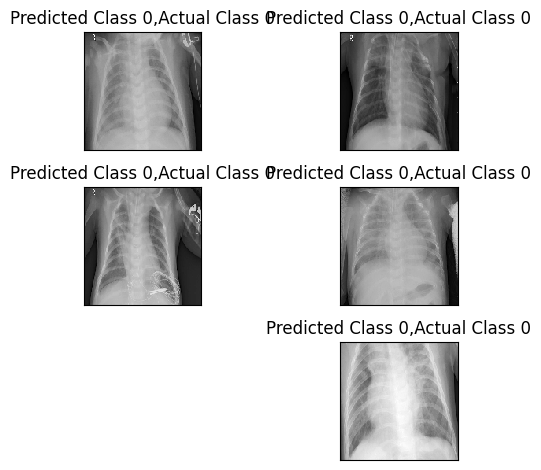

In [65]:
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(
        predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-66-b9cc46b9bc85>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


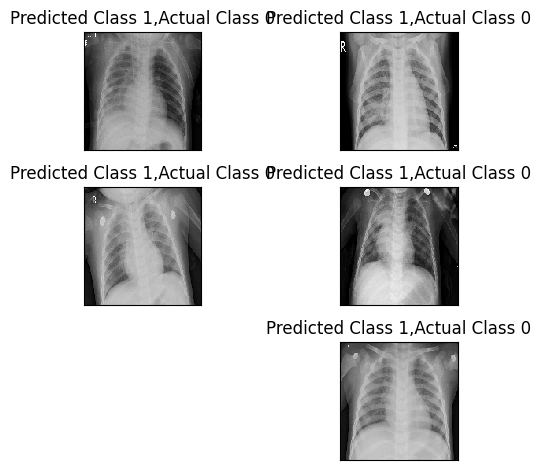

In [66]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1